In [1]:
import warnings
warnings.filterwarnings('ignore')

### Run in collab
<a href="https://colab.research.google.com/github/racousin/rl_introduction/blob/master/notebooks/1_Environment_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Objective
Here we present the type of problem that RL is addressing. And the main interactions between the environment and the agents.

In [4]:
import seaborn as sns
import numpy as np
from time import sleep
import matplotlib.pyplot as plt
import tensorflow as tf
import gym
from time import time,sleep
sns.set_style("darkgrid")

# 1_Environment_Agent

The environment encapsules the rules/transition model ($\mathbb{P}(S_{t+1},R_{t+1}|S_t,A_t)$) that gives feedback to the agent.

Science of environments is complex, particulary for real problems simulation (e.g for autonomous vehicules).

It is easiest when then environment is already completly defined (e.g Videos Games).

### Minimal environment class
The main part of a virtual environment is the <b>step</b> function. It takes the <b>action</b> and it returns a new <b>state</b>, the associated <b>reward</b>, a boolean (<b>done</b>) to inticate if it is a final step, and eventually some <b>info</b>.

In [5]:
class Env:
    def __init__(self):
        self.state = 0
        self.done = False
        
    def step(self, action):
        ...
        return state, reward, done, info
        
        
    def reset(self):
        self.__init__()
        return self.state

### Exemple of environment

This environment generates a random state number. If the action is the same parity, reward is $1$, otherwise reward is $-1$

**States:** $S = \{0,1\}$

**Actions:** $A = \mathbb{N^+}$

**Transition model:** $P_{ss'}^a = \mathbb{P} [S_{t+1} = s' \vert S_t = s, A_t = a]$

$\forall a \in A, \forall s,s' \in S : P_{ss'}^a = 0.5$

**Reward function:**
$R(s, a) = \mathbb{E} [R_{t+1} \vert S_t = s, A_t = a]$, $\textit{deterministic, in this case}$

$\forall a \in 2 \mathbb{N} : R(0,a) = 1$

$\forall a \in 2 \mathbb{N} + 1: R(1,a) = 1$

$\forall a \in 2 \mathbb{N} : R(1,a) = -1$

$\forall a \in 2 \mathbb{N} + 1 : R(0,a) = -1$

In [6]:
class Env_odd_even(Env):
    def step(self, action):
        if (action % 2 == 0 and self.state % 2 == 0) or (action % 2 == 1 and self.state % 2 == 1):
            reward = 1
        else:
            reward = -1
        self.state = np.random.randint(2)
        return self.state, reward, self.done, {}

In [7]:
env = Env_odd_even()

In [10]:
env.step(1)

(0, -1, False, {})

### Minimal agent class

The <b>act</b> function return an <b>action</b> for a <b>state</b> according to the agent policy.
A smart agent may learn and update its policy.

In [11]:
class Agent:
    def __init__(self, env):
        self.env = env
    def act(self, state):
        return action
    def train():
        pass

### Random agent
It acts randomly. It is useful as lower bound for benchmark.

**Policy:** $a_t \sim \pi(\cdot | s_t) \to \mathbb{P}(a_t|s_t)$

$\forall s \in S : \mathbb{P}(a=0|s) = \mathbb{P}(a=1|s) = 0.5$

In [12]:
class MyRandomAgent(Agent):
    def act(self, state):
        action = np.random.randint(2)
        return action

In [16]:
agent = MyRandomAgent(env)
agent.act(0)

1

### Super agent
When we know the best policy. It serves as higher bound for the benchmark and it allows to compute the regret.


**Policy:**

$\mathbb{P}(a=0|s=0) = \mathbb{P}(a=1|s=1) = 1$

$\mathbb{P}(a=1|s=0) = \mathbb{P}(a=0|s=1) = 0$

In [17]:
class MySuperAgent(Agent):
    def act(self, state):
        if state % 2 == 0:
            action = 0
        else:
            action = 1
        return action

### Compute rewards in agent-environment interaction 

Now, we want to compare the performance of our agents. The empirical way to do it is to observe the cumulative reward (following the agent policy).

**Generate trajectory:** $\tau$ following the policy $\pi$ $S_1,A_1,R_2,…,S_T$ to compute an estimation of Return $G_t = \sum_{k=0}^{T-t-1} \gamma^k R_{t+k+1}$

In [19]:
def run_experiment(env, agent, nb_step):
    rewards = np.zeros(nb_step)
    state = env.reset()
    for i in range(nb_step):
        action = agent.act(state) #agent chooses action
        state, reward, done, info = env.step(action) # feedback of environment
        rewards[i] = reward
    return rewards

In [20]:
nb_step = 100

Text(0.5, 1.0, 'cumulative reward - random_agent')

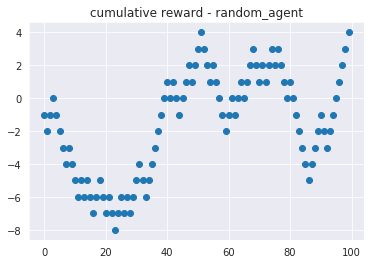

In [21]:
env = Env_odd_even()
my_random_agent = MyRandomAgent(env)
rewards = run_experiment(env, my_random_agent, nb_step)
plt.plot(rewards.cumsum(), 'o')
plt.title('cumulative reward - random_agent')

Text(0.5, 1.0, 'cumulative reward - super_agent')

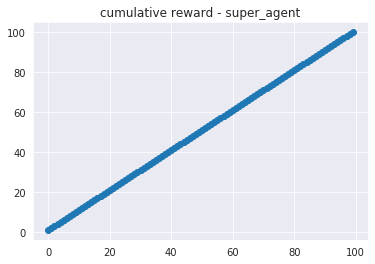

In [22]:
env = Env_odd_even()
my_super_agent = MySuperAgent(env)
rewards = run_experiment(env, my_super_agent, nb_step)
plt.plot(rewards.cumsum(),'o')
plt.title('cumulative reward - super_agent')

We can calculate **the expected return:** $ J(\pi) = E_{\tau\sim \pi}[{G(\tau)}] = \int_{\tau} \mathbb{P}(\tau|\pi) G(\tau)$ using the transition model  $ \mathbb{P}(\tau|\pi) = \rho_0 (s_0) \prod_{t=0}^{T-1} P(s_{t+1} | s_t, a_t) \pi(a_t | s_t)$

For the random policy $J(\pi) = 0$ and regret is T

For the optimal policy $J(\pi^*) = T$ and regret is 0

### Exemple of environment with episode end
Environment generate a random state number. If the action is the same parity, reward is $1$, otherwise reward is $-1$. If the agent wins 3 consectives times, the episode ends. After 500 iterations, episode ends.

**States:** $S = \{S_1, S_2, S_3\} = \{\{0,1\}, \{0,1,2\}, \{1,...,500\}\} $

**Actions:** $A = \mathbb{N^+}$

**Transition model:** Also a marckov chain model

First dimension of the state is following the same law as before
$\forall a \in A, \forall s,s' \in S_1 : P_{ss'}^a = 0.5$

**Reward function:** it depends only on first state dimension


$\forall a \in 2, \forall s_2,s_3 \in S_2, S_3 \mathbb{N} : R((0,s_2,s_3),a) = 1$

$\forall a \in 2 \mathbb{N} + 1, \forall s_2,s_3 \in S_2, S_3: R((1,s_2,s_3),a) = 1$

$\forall a \in 2 \mathbb{N}, \forall s_2,s_3 \in S_2, S_3 : R((1,s_2,s_3),a) = -1$

$\forall a \in 2 \mathbb{N} + 1, \forall s_2,s_3 \in S_2, S_3 : R((0,s_2,s_3),a) = -1$

In [23]:
class Env_odd_even2(Env):
    def __init__(self):
        self.state1 = 0
        self.nb_win = 0
        self.limit_game = 500
        self.state = (self.state1, self.nb_win, self.limit_game)
        self.done = False
    def step(self, action):
        if (action % 2 == 0 and self.state1 % 2 == 0) or (action % 2 == 1 and self.state1 % 2 == 1):
            self.nb_win += 1
            reward = 1
        else:
            self.nb_win = 0
            reward = -1
        self.state1 = np.random.randint(2)
        if self.nb_win == 3 or self.limit_game == 0:
            self.done = True
        self.limit_game -= 1
        self.state = (self.state1, self.nb_win, self.limit_game)
        return self.state, reward, self.done, {}

Now, we observe the cumulative reward through trajectories (following the agent policy).

In [24]:
def run_experiment_episode(env, agent, nb_episode, is_using_first_state_only=False):
    rewards = np.zeros(nb_episode)
    for i in range(nb_episode):
        state = env.reset() 
        done = False
        rews = []
        while done is False:
            if is_using_first_state_only:
                state = state[0] # for agent using only the first dimension state
            action = agent.act(state)
            state, reward, done, info = env.step(action)
            rews.append(reward)
        rewards[i] = sum(rews)
    return rewards

Text(0.5, 1.0, 'cumulative reward per episode - random_agent')

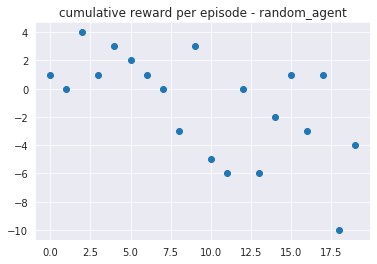

In [27]:
env = Env_odd_even2()
rewards = run_experiment_episode(env, my_random_agent, 20)
plt.plot(rewards, 'o')
plt.title('cumulative reward per episode - random_agent')

Text(0.5, 1.0, 'cumulative reward per episode - super_agent')

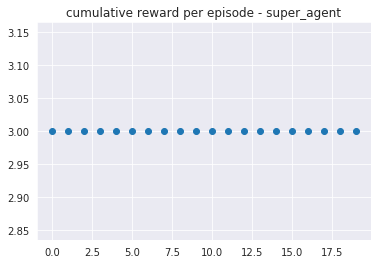

In [26]:
env = Env_odd_even2()
rewards = run_experiment_episode(env, my_super_agent, 20, is_using_first_state_only=True)
plt.plot(rewards,'o')
plt.title('cumulative reward per episode - super_agent')

The super agent is far to be the best for the new environment

# ENVIRONMENT FROM OPENAI
https://gym.openai.com/envs/#atari

## Discrete state action environment

### NChain

<img src="images/NChain-illustration.png">

In [28]:
env = gym.make('NChain-v0')
print('description action space:', env.action_space)
print('description observation space:', env.observation_space)
print('run some random iteration:')
env.reset()
for _ in range(3):
    print()
    action = env.action_space.sample()
    print('action: ')
    print(action)
    state, reward, done, info = env.step(action)
    print('state: ')
    print(state)
    print('reward: ')
    print(reward)

description action space: Discrete(2)
description observation space: Discrete(5)
run some random iteration:

action: 
1
state: 
0
reward: 
2

action: 
1
state: 
0
reward: 
2

action: 
0
state: 
1
reward: 
0


## Discrete action continuous space environment

### CartPole
A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The system is controlled by applying a force of +1 or -1 to the cart. The pendulum starts upright, and the goal is to prevent it from falling over. A reward of +1 is provided for every timestep that the pole remains upright. The episode ends when the pole is more than 15 degrees from vertical, or the cart moves more than 2.4 units from the center.
<img src="images/CartPole-v1.png">
observations: position of cart, velocity of cart, angle of pole, rotation rate of pole

In [30]:
env = gym.make('CartPole-v0')
env.reset()
print('description action space:', env.action_space)
print('description observation space:', env.observation_space)
print('run some random iteration:')
for _ in range(3):
    print()
    action = env.action_space.sample()
    print('action: ')
    print(action)
    state, reward, done, info = env.step(action)
    print('state: ')
    print(state)
    print('reward: ')
    print(reward)

description action space: Discrete(2)
description observation space: Box(4,)
run some random iteration:

action: 
0
state: 
[ 0.00553366 -0.20095422  0.03346941  0.25939398]
reward: 
1.0

action: 
1
state: 
[ 0.00151458 -0.00632566  0.03865729 -0.02254718]
reward: 
1.0

action: 
1
state: 
[ 0.00138806  0.1882212   0.03820635 -0.30278704]
reward: 
1.0


Most of the environments are provide with a render:

In [31]:
time_steps = 150
state = env.reset()
for _ in range(time_steps):
    action = env.action_space.sample()
    _, _, done, _ = env.step(action)
    if done is True:
        state = env.reset()
        print('reset')
    env.render()
    sleep(0.1)
env.close()

reset
reset
reset
reset
reset
reset
reset


## Continuous action-space environment

### MountainCarContinuous
An underpowered car must climb a one-dimensional hill to reach a target. Unlike MountainCar v0, the action (engine force applied) is allowed to be a continuous value.

The target is on top of a hill on the right-hand side of the car. If the car reaches it or goes beyond, the episode terminates.

On the left-hand side, there is another hill. Climbing this hill can be used to gain potential energy and accelerate towards the target. On top of this second hill, the car cannot go further than a position equal to -1, as if there was a wall. Hitting this limit does not generate a penalty (it might in a more challenging version).
<img src="images/MountainCarContinuous-v0.png">

In [53]:
env = gym.make('MountainCarContinuous-v0')
env.reset()
print('description action space:', env.action_space)
print('description observation space:', env.observation_space)
print('run some random iteration:')
for _ in range(3):
    print()
    action = env.action_space.sample()
    print('action: ')
    print(action)
    state, reward, done, info = env.step(action)
    print('state: ')
    print(state)
    print('reward: ')
    print(reward)

description action space: Box(1,)
description observation space: Box(2,)
run some random iteration:

action: 
[-0.4499425]
state: 
[-5.90841714e-01 -1.75293389e-04]
reward: 
-0.020244825276558576

action: 
[0.25664103]
state: 
[-0.59013114  0.00071058]
reward: 
-0.0065864618439391625

action: 
[0.6057256]
state: 
[-0.58801629  0.00211485]
reward: 
-0.03669034860369926


In [54]:
time_steps = 500
state = env.reset()
for _ in range(time_steps):
    action = env.action_space.sample()
    _, _, done, _ = env.step(action)
    if done is True:
        state = env.reset()
        print('reset')
    env.render()
    sleep(0.01)
env.close()

### LunarLanderContinuous
Landing pad is always at coordinates (0,0). Coordinates are the first two numbers in state vector. Reward for moving from the top of the screen to landing pad and zero speed is about 100..140 points. If lander moves away from landing pad it loses reward back. Episode finishes if the lander crashes or comes to rest, receiving additional -100 or +100 points. Each leg ground contact is +10. Firing main engine is -0.3 points each frame. Solved is 200 points. Landing outside landing pad is possible. Fuel is infinite, so an agent can learn to fly and then land on its first attempt. Action is two real values vector from -1 to +1. First controls main engine, -1..0 off, 0..+1 throttle from 50% to 100% power. Engine can't work with less than 50% power. Second value -1.0..-0.5 fire left engine, +0.5..+1.0 fire right engine, -0.5..0.5 off.
<img src="images/LunarLanderContinuous-v2.png">

In [55]:
env = gym.make('LunarLanderContinuous-v2')
env.reset()
print('description action space:', env.action_space)
print('description observation space:', env.observation_space)
print('run some random iteration:')
print()
for _ in range(3):
    action = env.action_space.sample()
    print('action: ')
    print(action)
    state, reward, done, info = env.step(action)
    print('state: ')
    print(state)
    print('reward: ')
    print(reward)

description action space: Box(2,)
description observation space: Box(8,)
run some random iteration:

action: 
[0.52208775 0.46684158]
state: 
[ 0.00425587  1.386812    0.21566638 -0.5286772  -0.00482158 -0.04736646
  0.          0.        ]
reward: 
2.0107786841779216
action: 
[0.06690918 0.22630452]
state: 
[ 0.00638762  1.3747944   0.21558455 -0.534123   -0.00720027 -0.04757822
  0.          0.        ]
reward: 
0.30148395800757727
action: 
[ 0.02702711 -0.19252296]
state: 
[ 0.00846577  1.362733    0.21048145 -0.53607756 -0.00984949 -0.05298946
  0.          0.        ]
reward: 
0.7931713087489299


In [56]:
time_steps = 500
state = env.reset()
for _ in range(time_steps):
    action = env.action_space.sample()
    _, _, done, _ = env.step(action)
    if done is True:
        state = env.reset()
        print('reset')
    env.render()
    sleep(0.01)
env.close()

reset
reset
reset
reset


## High space dimension environment

### Atari games


In [32]:
env = gym.make('Pong-v0')
env.reset()
print('description action space:', env.action_space)
print('description observation space:', env.observation_space)
print('run some random iteration:')
print()
for _ in range(3):
    action = env.action_space.sample()
    print('action: ')
    print(action)
    state, reward, done, info = env.step(action)
    print('state: ')
    print(state)
    print('reward: ')
    print(reward)

description action space: Discrete(6)
description observation space: Box(210, 160, 3)
run some random iteration:

action: 
1
state: 
[[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [144  72  17]
  [144  72  17]
  [144  72  17]]

 [[144  72  17]
  [144  72  17]
  [144  72  17]
  ...
  [144  72  17]
  [144  72  17]
  [144  72  17]]

 [[144  72  17]
  [144  72  17]
  [144  72  17]
  ...
  [144  72  17]
  [144  72  17]
  [144  72  17]]

 ...

 [[236 236 236]
  [236 236 236]
  [236 236 236]
  ...
  [236 236 236]
  [236 236 236]
  [236 236 236]]

 [[236 236 236]
  [236 236 236]
  [236 236 236]
  ...
  [236 236 236]
  [236 236 236]
  [236 236 236]]

 [[236 236 236]
  [236 236 236]
  [236 236 236]
  ...
  [236 236 236]
  [236 236 236]
  [236 236 236]]]
reward: 
0.0
action: 
4
state: 
[[[  0   0   0]
  [  0   0   0]
  [  0   0   0]
  ...
  [144  72  17]
  [144  72  17]
  [144  72  17]]

 [[144  72  17]
  [144  72  17]
  [144  72  17]
  ...
  [144  72  17]
  [144  72  17]
  [144  72  17]

In [58]:
time_steps = 1000
state = env.reset()
for _ in range(time_steps):
    action = env.action_space.sample()
    _, _, done, _ = env.step(action)
    if done is True:
        state = env.reset()
        print('reset')
    env.render()
    sleep(0.004)
env.close()

# Evaluate Random agent in open ai gym

In [59]:
env = gym.make('Pong-v0')

In [37]:
class RandomAgent(Agent):
    def act(self, state):
            return self.env.action_space.sample()

Text(0.5, 1.0, 'cumulative reward per episode - rand_agent')

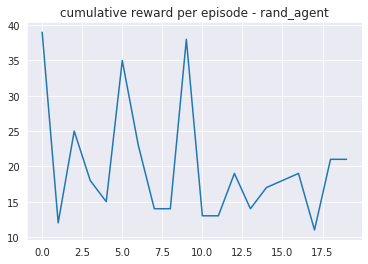

In [70]:
rand_agent = RandomAgent(env)
rewards = run_experiment_episode(env, rand_agent, 20)
plt.plot(rewards)
plt.title('cumulative reward per episode - rand_agent')

### Collab Render

In [ ]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1

In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1

In [ ]:
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

In [ ]:
import gym
import numpy as np

In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

In [ ]:
env = gym.make("CartPole-v0")
#env = gym.make('Pong-v0')
#env = gym.make('LunarLanderContinuous-v2')
#env = gym.make('BipedalWalker-v2')
env.reset()
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)

for i in range(50):
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    screen = env.render(mode='rgb_array')
    
    plt.imshow(screen)
    ipythondisplay.clear_output(wait=True)
    ipythondisplay.display(plt.gcf())
    sleep(0.004)
    
    if done:
        break

ipythondisplay.clear_output(wait=True)
env.close()

### Build your CartPole euristic agent

In [33]:
env = gym.make('CartPole-v0')

In [35]:
class MyCartPoleAgent(Agent):
    def __init__(self, env, params=[0.27,-0.1,-0.5,-0.2,0.2, 0, 1]):
        super().__init__(env)
        self.params = params
    def act(self, state):
        if state[0] > self.params[0] and state[2] > self.params[1] and state[3] <= self.params[2]:
            action = 0
        elif state[3] > self.params[4] and state[1] >= self.params[5] and state[1] <= self.params[6]:
            action = 1
        else:
            action = 1
        return action

total reward random: 11302.0
total reward param 0: 4680.0
total reward param 1: 4679.0
total reward param 2: 84418.0


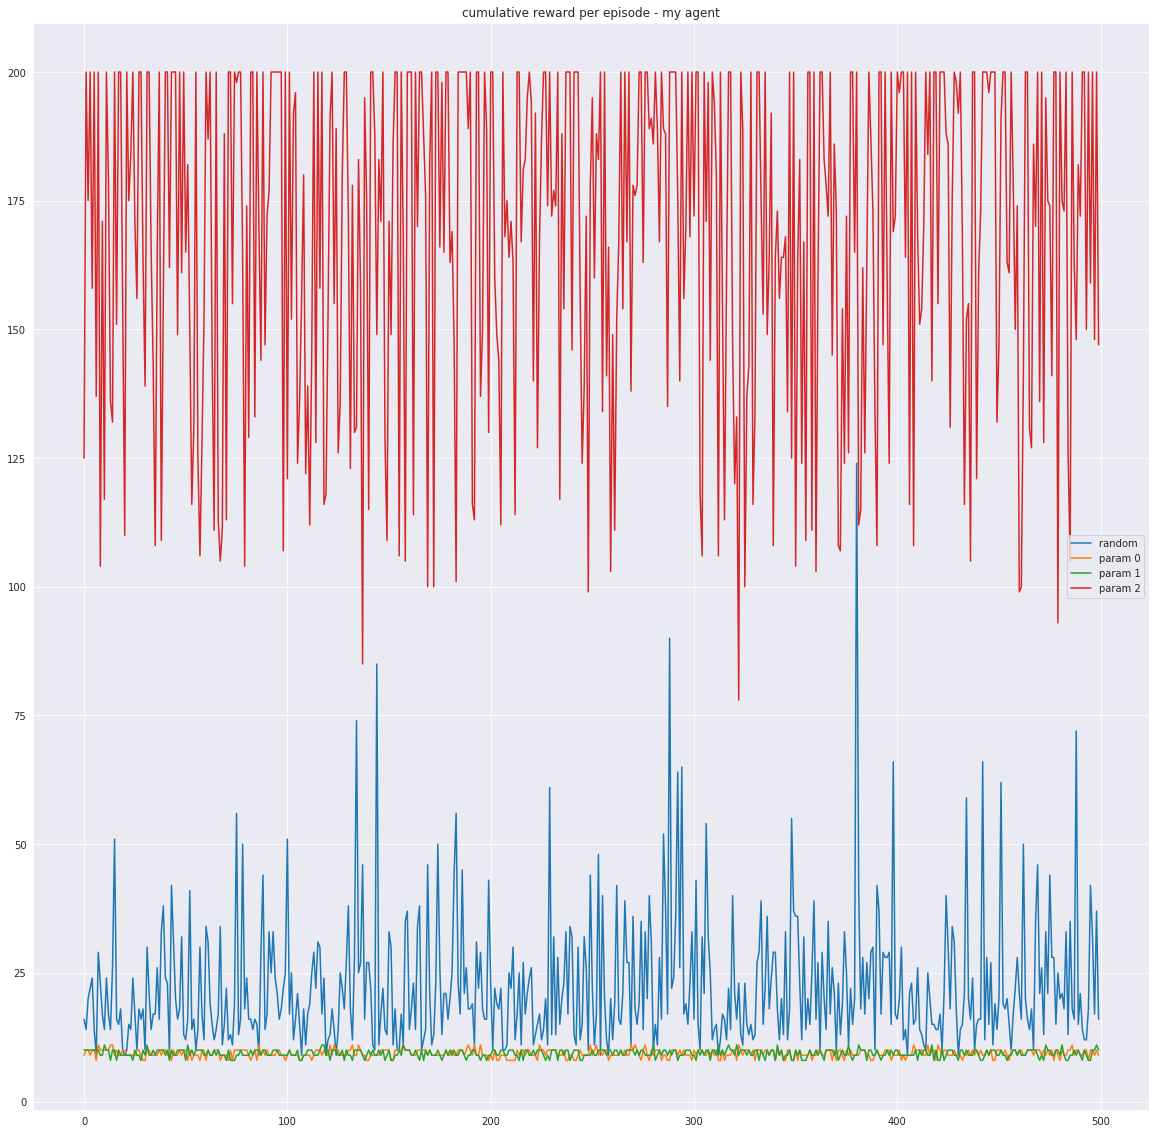

In [39]:
params0 = [0.27,-0.1,-0.5,-0.2,0.2, 0, 0]
params1 = [-0.27,0.1,0.5,0.2,-0.2, -0.1, 0.1]
params2 = [-0.9,-0.1,0,0,-0.9, 0, 0.9]

nb_experience = 500

plt.figure(figsize=(20,20))
rand_agent = RandomAgent(env)
rewards = run_experiment_episode(env, rand_agent, nb_experience)
print(f'total reward random: {sum(rewards)}')
plt.plot(rewards, label=f'random ')
for i, param in enumerate([params0, params1, params2]):
    rand_agent = MyCartPoleAgent(env,params=param)
    rewards = run_experiment_episode(env, rand_agent, nb_experience)
    print(f'total reward param {i}: {sum(rewards)}')
    plt.plot(rewards, label=f'param {i}')
plt.title('cumulative reward per episode - my agent')
plt.legend()